In [1]:
import dhlab as dh
import pandas as pd
from dhlab import nbtokenizer

In [2]:
pd.set_option('max_colwidth', 400)

In [3]:
from collections import Counter
def score_words_title(corpus, ref_corpus, head=10, relecance_cut=10):
    local_words = Counter(dh.nbtokenizer.tokenize(' '.join(str(x) for x in list(corpus.frame.title)).lower()))
    ref_words = Counter(dh.nbtokenizer.tokenize(' '.join(str(x) for x in list(ref_corpus.frame.title)).lower()))
    local_words_frame = pd.DataFrame(local_words.items(), columns=["word", "freq"]).set_index("word")
    ref_words_frame = pd.DataFrame(ref_words.items(), columns=["word", "freq"]).set_index("word")
    local_words_frame["relfreq"] = local_words_frame["freq"] / local_words_frame.freq.sum()
    ref_words_frame["relfreq"] = ref_words_frame["freq"] / ref_words_frame.freq.sum()
    merged_frame = pd.merge(local_words_frame, ref_words_frame, left_index=True, right_index=True)
    merged_frame["relevance"] = merged_frame.relfreq_x / merged_frame.relfreq_y
    sorted_merged_frame = merged_frame.sort_values(by=["relevance"], ascending=False)
    keyness = sorted_merged_frame[sorted_merged_frame.relevance > relecance_cut].sort_values(by="freq_x", ascending=False).head(head)
    return (local_words_frame, ref_words_frame, keyness)

def score_words_fulltext(corpus, ref_corpus, head=10, relecance_cut=10):
    corpus_cnt = corpus.count(words=sentiment_words)
    ref_corpus_cnt = ref_corpus.count(words=sentiment_words)

    # find total frequency
    total_corpus = corpus_cnt.freq.transpose() / corpus_cnt.relfreq.transpose()
    # pick the first non-NaN value for each dlabid
    total_corpus = pd.DataFrame(total_corpus.bfill(axis=1).iloc[:, 0])
    totalfreq_corpus = total_corpus.sum().iloc[0]
    
    total_ref_corpus = ref_corpus_cnt.freq.transpose() / ref_corpus_cnt.relfreq.transpose()
    # pick the first non-NaN value for each dlabid
    total_ref_corpus = pd.DataFrame(total_ref_corpus.bfill(axis=1).iloc[:, 0])
    totalfreq_ref_corpus = total_ref_corpus.sum().iloc[0]
    
    local_words_frame = corpus_cnt.sum().frame
    ref_words_frame = ref_corpus_cnt.sum().frame
    local_words_frame["relfreq"] = local_words_frame["freq"] / totalfreq_corpus
    ref_words_frame["relfreq"] = ref_words_frame["freq"] / totalfreq_ref_corpus
    merged_frame = pd.merge(local_words_frame, ref_words_frame, left_index=True, right_index=True)
    merged_frame["relevance"] = merged_frame.relfreq_x / merged_frame.relfreq_y
    sorted_merged_frame = merged_frame.sort_values(by=["relevance"], ascending=False)
    keyness = sorted_merged_frame[sorted_merged_frame.relevance > relecance_cut].sort_values(by="freq_x", ascending=False).head(head)
    return (local_words_frame, ref_words_frame, keyness)

# sentiment analysis
import sentiment
positives, negatives = sentiment.load_norsentlex()
sentiment_words = list(positives.terms) + list(negatives.terms)
def score_sentiment(local_words_frame):
    pos, neg = sentiment.load_norsentlex()
    merged_frame_2 = local_words_frame.reset_index()
    merged_frame_2["pos"] = merged_frame_2.apply(lambda x: x.relfreq if x.word in list(pos.terms) else 0, axis=1)
    merged_frame_2["neg"] = merged_frame_2.apply(lambda x: x.relfreq if x.word in list(neg.terms) else 0, axis=1)
    return (merged_frame_2["pos"].sum() * 100, merged_frame_2["neg"].sum() * 100)

In [4]:
def sent_counter(text):
    return sentiment.score_sentiment(text=text, positive=positives, negative=negatives)

## Create a corpus of 641 books and a reference corpus from the same period

Criteria:
- Only books in Norwegian Bokmål (= nob as the first language in the langs field)
- Between 1950 and 2024

In [5]:
# get all books from the API
#food_corpus = dh.Corpus(doctype="digibok", ddk="641*", from_year=1950, to_year=2024, lang="nob", limit=5000)
#food_corpus = dh.Corpus().from_df(food_corpus.frame[food_corpus.frame.langs.apply(lambda x: x.startswith("nob"))])
food_corpus = dh.Corpus.from_df(pd.read_excel("corpus.xlsx"))

In [6]:
# get all books from the API, then sample with a seed locally
#sample_total_ref = dh.Corpus(doctype="digibok", from_year=1950, to_year=2024, lang="nob", limit=500000)
#sample_total_ref = dh.Corpus().from_df(sample_total_ref.frame[sample_total_ref.frame.langs.apply(lambda x: x.startswith("nob"))].sample(n=4250, random_state=1))
sample_total_ref = dh.Corpus().from_df(pd.read_excel("ref_corpus.xlsx"))

In [7]:
# get frequencies for titles and fulltext, compare with reference
local_words_frame, ref_words_frame, keyness_title = score_words_title(food_corpus, sample_total_ref, head=200)
local_words_frame_ft, ref_words_frame_ft, keyness_ft = score_words_fulltext(food_corpus, sample_total_ref, head=200)

In [8]:
# table 3
local_words_frame.sort_values(by="freq", ascending=False).head(10)

,freq,relfreq
word,,
:,2263,0.081948
og,1296,0.046931
",",897,0.032482
mat,590,0.021365
fra,495,0.017925
for,469,0.016984
i,409,0.014811
til,399,0.014449
en,378,0.013688


In [9]:
# table 4
ref_words_frame.sort_values(by="freq", ascending=False).head(10)

,freq,relfreq
word,,
:,2664,0.079079
og,1495,0.044378
i,1182,0.035087
av,695,0.020630
",",656,0.019473
for,621,0.018434
en,433,0.012853
til,373,0.011072
.,369,0.010953


In [10]:
# table 5
keyness_title.sort_values(by="freq_x", ascending=False).head(10)

,freq_x,relfreq_x,freq_y,relfreq_y,relevance
word,,,,,
mat,590,0.021365,8,0.000237,89.968858
oppskrifter,348,0.012602,2,0.000059,212.265508
beste,163,0.005903,8,0.000237,24.855803
godt,140,0.005070,6,0.000178,28.464723
vin,102,0.003694,2,0.000059,62.215752
kaker,87,0.003150,2,0.000059,53.066377
verdens,85,0.003078,8,0.000237,12.961615
god,82,0.002969,10,0.000297,10.003317
gode,80,0.002897,8,0.000237,12.199167


In [11]:
# how large is the corpus?
# number of docs
print(len(food_corpus))

4250


In [12]:
# count words in title
print(local_words_frame["freq"].sum())
print(ref_words_frame["freq"].sum())

27615
33688


In [13]:
# count types in title
print(len(local_words_frame))
print(len(ref_words_frame))

5335
11172


In [14]:
# lookup 'fra' in the reference corpus
ref_words_frame.loc["fra"]["relfreq"] * 100

1.0033246259795772

## Look at some examples

In [15]:
food_corpus.frame["title_sentiment"] = food_corpus["title"].apply(lambda x: sent_counter(x.lower()))
food_corpus.frame["positive"] = food_corpus["title_sentiment"].apply(lambda x: x[0])
food_corpus.frame["negative"] = food_corpus["title_sentiment"].apply(lambda x: x[1])

In [16]:
food_corpus.frame.sort_values(by="positive", ascending=False)[["title", "positive"]].head(5)

,title,positive
2273,Sunt snop & snacks : 23 fantastiske søte og salte oppskrifter på sunne godsaker som kan nytes med god samvittighet,6
322,Moderne kosthold : en sikker grunnvoll for familiens helse : bedre økonomi - mindre tretthet - større energi,6
2865,Sunn mat når du får cellegift : en kokk og en lege har slått seg sammen for å inspirere deg med over 100 delikate retter,6
1308,"Annabel Karmel ' s matpakker og snacks : mer enn 120 sunne oppskrifter på supergode matpakker for barn og voksne ! : nydelige smørbrød , friske salater , varmende supper og søte godbiter !",6
4095,Balanse i tarmen : den enkle veien til bedre helse : fem trinn som helbreder tarmen,5


## Look at sentiment of titles

In [17]:
local_pos, local_neg = score_sentiment(local_words_frame)
local_title_diff = local_pos - local_neg
ref_pos, ref_neg = score_sentiment(ref_words_frame)
ref_title_diff = ref_pos - ref_neg

In [18]:
print("Food corpus:")
print("Positive:", local_pos)
print("Negative:", local_neg)
print("Reference corpus:")
print("Positive:", ref_pos)
print("Negative:", ref_neg)

Food corpus:
Positive: 9.856961796125297
Negative: 3.23012855332247
Reference corpus:
Positive: 3.6719306578009974
Negative: 3.0930895274281647


In [19]:
print("Diff in food corpus:", local_title_diff)
print("Diff in reference corpus:", ref_title_diff)

Diff in food corpus: 6.626833242802827
Diff in reference corpus: 0.5788411303728327


In [20]:
food_corpus.count(words=["god", "dårlig"]).sum()

,freq
word,
dårlig,12782.0
god,126875.0


In [21]:
sample_total_ref.count(words=["god", "dårlig"]).sum()

,freq
word,
dårlig,24999.0
god,68694.0


In [ ]:
food_corpus.to_excel("corpus.xlsx")

In [ ]:
sample_total_ref.to_excel("ref_corpus.xlsx")

## Look at sentiment of fulltext

In [22]:
local_pos_ft, local_neg_ft = score_sentiment(local_words_frame_ft)
local_ft_diff = local_pos_ft - local_neg_ft
ref_pos_ft, ref_neg_ft = score_sentiment(ref_words_frame_ft)
ref_ft_diff = ref_pos_ft - ref_neg_ft

In [23]:
print("Food corpus:")
print("Positive:", local_pos_ft)
print("Negative:", local_neg_ft)
print("Reference corpus:")
print("Positive:", ref_pos_ft)
print("Negative:", ref_neg_ft)

Food corpus:
Positive: 4.924992846687165
Negative: 4.777066335001884
Reference corpus:
Positive: 4.5468545930667945
Negative: 4.73204403642502


In [24]:
print("Diff in food corpus (ft):", local_ft_diff)
print("Diff in reference corpus (ft):", ref_ft_diff)

Diff in food corpus (ft): 0.1479265116852817
Diff in reference corpus (ft): -0.18518944335822507


In [30]:
# number of tokens in ft corpus

In [29]:
local_words_frame_ft.loc["abnorm"]["freq"] / local_words_frame_ft.loc["abnorm"]["relfreq"]

168345077.0

In [31]:
ref_words_frame_ft.loc["abnorm"]["freq"] / ref_words_frame_ft.loc["abnorm"]["relfreq"]

216359525.0

# Compare all Dewey series

In [ ]:
#for x in range(0,10):
    #print(x)
    #corpus = dh.Corpus(doctype="digibok", ddk="%s*" % (str(x)), lang="nob", limit=500000)
    #corpus = dh.Corpus().from_df(corpus.frame[corpus.frame.langs.apply(lambda x: x.startswith("nob"))])

    #if len(corpus) < 4250:
        #samplesize = len(corpus)
    #else:
        #samplesize = 4250
        
    #corpus = dh.Corpus().from_df(corpus.frame.sample(n=samplesize, random_state=1))
    #corpus.to_excel("corpus_%s.xlsx" % (str(x)))

In [43]:
corpus_0 = dh.Corpus().from_df(pd.read_excel("corpus_0.xlsx"))
corpus_1 = dh.Corpus().from_df(pd.read_excel("corpus_1.xlsx"))
corpus_2 = dh.Corpus().from_df(pd.read_excel("corpus_2.xlsx"))
corpus_3 = dh.Corpus().from_df(pd.read_excel("corpus_3.xlsx"))
corpus_4 = dh.Corpus().from_df(pd.read_excel("corpus_4.xlsx"))
corpus_5 = dh.Corpus().from_df(pd.read_excel("corpus_5.xlsx"))
corpus_6 = dh.Corpus().from_df(pd.read_excel("corpus_6.xlsx"))
corpus_7 = dh.Corpus().from_df(pd.read_excel("corpus_7.xlsx"))
corpus_8 = dh.Corpus().from_df(pd.read_excel("corpus_8.xlsx"))
corpus_9 = dh.Corpus().from_df(pd.read_excel("corpus_9.xlsx"))

In [44]:
corpora = [corpus_0, corpus_1, corpus_2, corpus_3, corpus_4, corpus_5, corpus_6, corpus_7, corpus_8, corpus_9]

In [45]:
total_ref = pd.concat([corpus_0.frame, corpus_1.frame, corpus_2.frame, corpus_3.frame, corpus_4.frame, corpus_5.frame, corpus_6.frame, corpus_7.frame, corpus_8.frame, corpus_9.frame]).reset_index(drop=True)

In [46]:
total_ref_corpus = dh.Corpus().from_df(total_ref)

In [47]:
score_frame = {}

In [48]:
for idx, corpus in enumerate(corpora):
    dewey = "%s00" % (str(idx))
    print(dewey)
    local_words_frame, ref_words_frame, keyness_title = score_words_title(corpus, sample_total_ref, relecance_cut=500)
    local_words_frame_ft, ref_words_frame_ft, keyness_ft = score_words_fulltext(corpus, sample_total_ref, relecance_cut=500)
    
    sent_local_title = score_sentiment(local_words_frame)
    print("Titles (%s):" % (dewey), sent_local_title)
    sent_ref_title = score_sentiment(ref_words_frame)
    print("Titles (reference):", sent_ref_title)
    sent_local_ft = score_sentiment(local_words_frame_ft)
    print("Fulltext (%s):" % (dewey), sent_local_ft)
    sent_ref_ft = score_sentiment(ref_words_frame_ft)
    print("Fulltext (reference):", sent_ref_ft)
    score_frame[dewey] = {"local_words_frame": local_words_frame, "ref_words_frame": ref_words_frame, "keyness_title": keyness_title, "local_words_frame_ft": local_words_frame_ft, "ref_words_frame_ft": ref_words_frame_ft, "keyness_ft": keyness_ft, "sent_local_title": sent_local_title, "sent_ref_title": sent_ref_title, "sent_local_ft": sent_local_ft, "sent_ref_ft": sent_ref_ft}

000
Titles (000): (3.383287229838587, 2.222087120406116)
Titles (reference): (3.6719306578009974, 3.0930895274281647)
Fulltext (000): (3.691040953216005, 3.352599072422132)
Fulltext (reference): (4.5468545930667945, 4.73204403642502)
100
Titles (100): (7.669763488760586, 4.674540605492219)
Titles (reference): (3.6719306578009974, 3.0930895274281647)
Fulltext (100): (5.844624046525264, 5.268031968972398)
Fulltext (reference): (4.5468545930667945, 4.73204403642502)
200
Titles (200): (6.393759788717255, 2.9880539262352976)
Titles (reference): (3.6719306578009974, 3.0930895274281647)
Fulltext (200): (5.3660965557054485, 4.706737446853787)
Fulltext (reference): (4.5468545930667945, 4.73204403642502)
300
Titles (300): (3.875402164375548, 2.661596958174905)
Titles (reference): (3.6719306578009974, 3.0930895274281647)
Fulltext (300): (4.657780538401764, 4.028703578652414)
Fulltext (reference): (4.5468545930667945, 4.73204403642502)
400
Titles (400): (3.2809100959309583, 1.8045005527620273)
Tit

In [ ]:
def compare(dewey="400"):
    merge = pd.merge(score_frame[dewey]["local_words_frame_ft"], score_frame[dewey]["ref_words_frame_ft"], on="word")
    merge["keyness"] = merge.relfreq_x / merge.relfreq_y
    frame = merge.sort_values(by="keyness", ascending=False).head(50).sort_values(by="freq_x", ascending=False)
    print(dewey)
    print(frame)

In [ ]:
compare(dewey="900")

In [49]:
dewey_categories = {"000": "000 Computer Science",
"100": "100 Philosophy & Psychology",
"200": "200 Religion",
"300": "300 Social Sciences",
"400": "400 Language",
"500": "500 Science",
"600": "600 Technology",
"700": "700 Arts & Recreation",
"800": "800 Literature",
"900": "900 History & Geography",
"641": "641 Food and drink",
"999": "Reference corpus"}

In [50]:
data = dict()
for dewey in score_frame:
    label = dewey
    pos, neg = score_frame[dewey]["sent_local_title"]
    title_dist = pos - neg
    pos, neg = score_frame[dewey]["sent_local_ft"]
    ft_dist = pos - neg
    data[label] = [title_dist, ft_dist]

In [51]:
# add data from the food corpus
data["641"] = [local_title_diff, local_ft_diff]
data["999"] = [ref_title_diff, ref_ft_diff]

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

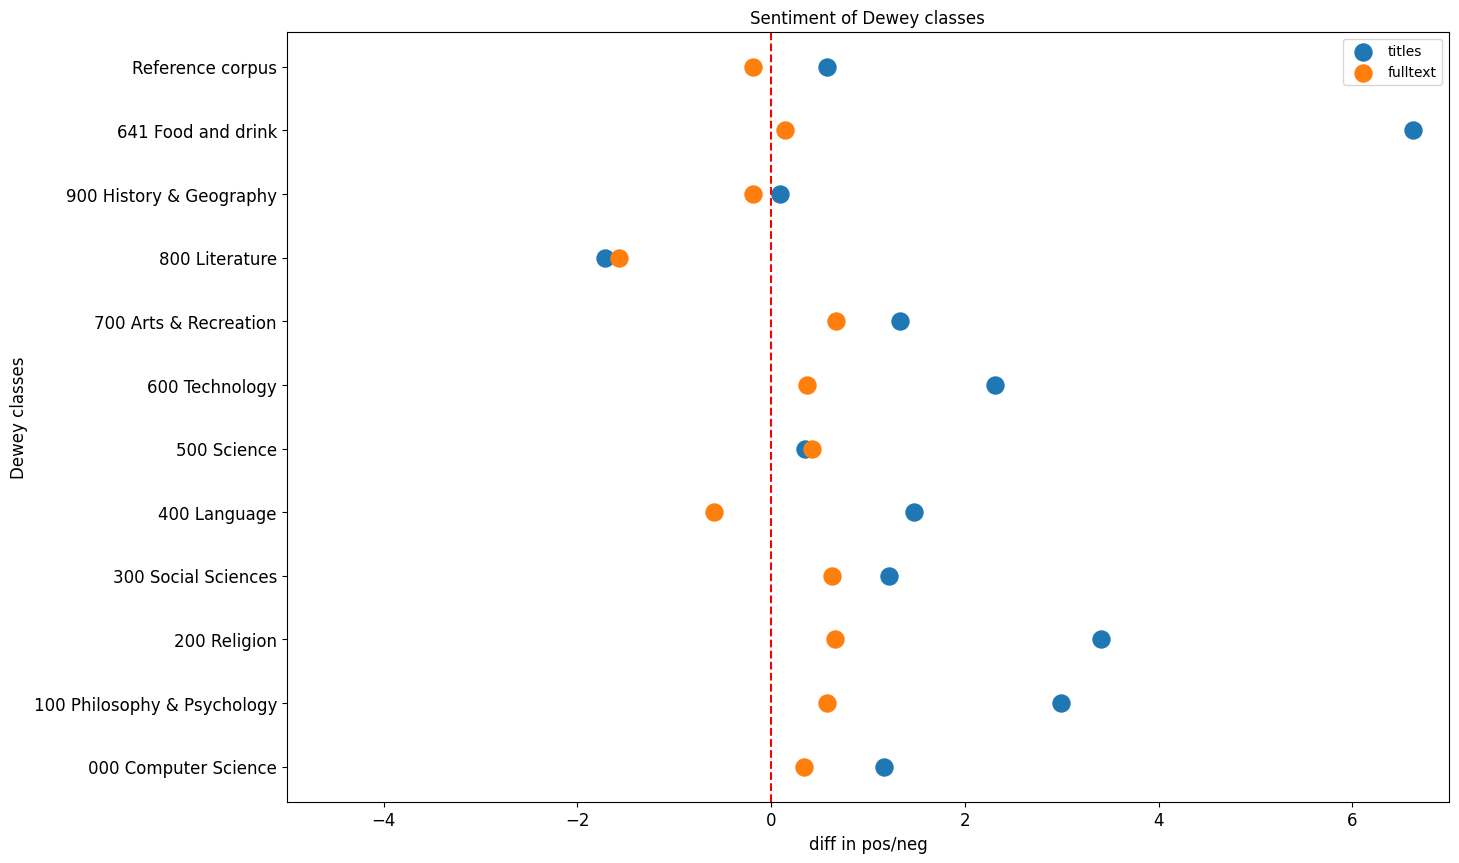

In [56]:
# Extract x and y values
y_values = [dewey_categories[key] for key in data.keys()]
x_values_1 = [value[0] for value in data.values()]
x_values_2 = [value[1] for value in data.values()]

# Create scatter plots for both datasets
plt.scatter(x_values_1, y_values, label='titles', s=150)
plt.scatter(x_values_2, y_values, label='fulltext', s=150)

# Customize the plot (optional)
plt.xlabel('diff in pos/neg', fontsize=12)
plt.ylabel('Dewey classes', fontsize=12)
plt.title('Sentiment of Dewey classes')
plt.legend()

plt.axvline(x=0, color='red', linestyle='--', label='x=0')

# Set x-axis limits to show numbers between -10 and 10
plt.xlim(-5, 7)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("sentiment.png", dpi='figure')

# Show the plot
plt.show()

<Figure size 1500x1000 with 0 Axes>

In [ ]:
corpus_2.frame["title_sentiment"] = corpus_2["title"].apply(lambda x: sent_counter(x.lower()))
corpus_2.frame["positive"] = corpus_2["title_sentiment"].apply(lambda x: x[0])
corpus_2.frame["negative"] = corpus_2["title_sentiment"].apply(lambda x: x[1])

In [ ]:
corpus_2.frame.sort_values(by="positive", ascending=False)[["title", "positive"]].head(15)

# Plot wordcloud

In [ ]:
import wordcloud
import matplotlib.pyplot as plt

In [ ]:
# lag ordsky
wc = wordcloud.WordCloud(background_color="white", prefer_horizontal=True, width=800, height=500)
wc.generate_from_frequencies(keyness_title.freq_x.to_dict())
plt.figure(figsize=(30,15))
plt.imshow(wc)
#plt.savefig('cloud.png')